In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install pydot graphviz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os


BASE_DIR = "/content/drive/MyDrive/Project/Image Captioning"

WORKING_DIR = os.path.join(BASE_DIR, "Inception-v3")

os.chdir(WORKING_DIR)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Project/Image Captioning/Inception-v3'

In [8]:
WORKING_DIR

'/content/drive/MyDrive/Project/Image Captioning/Inception-v3'

In [2]:
import os


BASE_DIR = "/kaggle/input"

WORKING_DIR = os.getcwd()

print("Working Directory:", WORKING_DIR)
print("Base Directory:", BASE_DIR)

Working Directory: /kaggle/working
Base Directory: /kaggle/input


In [ ]:
pip install tensorflow==1.14

In [ ]:


tf.executing_eagerly()


True

In [3]:
import pickle
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Embedding, LSTM, Dropout, Flatten, Input, add
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical, plot_model

2024-04-22 04:29:29.288220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 04:29:29.288317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 04:29:29.406786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import pandas as pd

captions_df = pd.read_csv(BASE_DIR + '/captions.txt')

captions_df.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

In [5]:
import re
for i in captions_df["image"]:
    x = re.search("([^\s]+(\.(?i)(jpg|png|gif|bmp))$)", i)
    if (x):
        pass
    else:
        print(f"YES! We have a match!: {i}")

/tmp/ipykernel_34/3266108744.py:3: DeprecationWarning: Flags not at the start of the expression '([^\\s]+(\\.(?i)(jpg|p' (truncated) but at position 10
  x = re.search("([^\s]+(\.(?i)(jpg|png|gif|bmp))$)", i)


In [5]:
captions_df.caption.values

array(['A child in a pink dress is climbing up a set of stairs in an entry way .',
       'A girl going into a wooden building .',
       'A little girl climbing into a wooden playhouse .', ...,
       'A person in a red shirt climbing up a rock face covered in assist handles .',
       'A rock climber in a red shirt .',
       'A rock climber practices on a rock climbing wall .'], dtype=object)

In [6]:
# Importing ResNet50 model with pre-trained ImageNet weights
resnet_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

# Getting the input and output layers of the ResNet50 model
new_input = resnet_model.input
hidden_layer = resnet_model.layers[-1].output

# Creating a feature extraction model using the input and output layers
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

# Displaying the summary of the feature extraction model
image_features_extract_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
import shutil

# Specify the source folder path from the dataset
src_folder = '/kaggle/input/flickr8k'

# Specify the destination folder path in your working directory
dst_folder = WORKING_DIR + "/flickr8k"

# Copy the folder and its contents to the working directory
shutil.copytree(src_folder, dst_folder)

In [7]:
dir = BASE_DIR + '/Images'

img_paths = []

for img_name in os.listdir(dir):
    img_path = dir + '/' + img_name
    img_paths.append(img_path)

print(len(img_paths))
print(img_paths[0])

8091
/kaggle/input/Images/3226254560_2f8ac147ea.jpg


In [8]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [9]:
def load_image(image_path):
    image_path_str = tf.strings.as_string(image_path)  # Convert tensor to string tensor
    image_name = tf.strings.split(tf.strings.split(image_path_str, '/')[-1], '.')[0]  # Extract image name
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_name

img = load_image(BASE_DIR + '/Images/3582465732_78f77f34ae.jpg')[0]
print(img.shape)

(224, 224, 3)


In [8]:
image_dataset = tf.data.Dataset.from_tensor_slices(img_paths)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

print(f"Let's check the BatchDataset shapes--> {image_dataset}")


Let's check the BatchDataset shapes--> <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [10]:
image_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
# %%time
# for img, path in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

In [ ]:
import shutil

save_dir = 'kaggle/working/Features'

#shutil.rmtree('/kaggle/working/flickr8k')

In [11]:
 os.makedirs('ResNet_Features', exist_ok = True)

In [ ]:
os.remove('/kaggle/working/Features/Tensor("args_0:0", shape=(), dtype=string).pkl')

In [ ]:
import shutil

shutil.rmtree('/content/drive/MyDrive/Project/Image Captioning/checkpoint_final')

In [ ]:
# for item in image_dataset.take(1):
#     print(item)

In [12]:
import pickle

save_dir = tf.constant(WORKING_DIR + '/ResNet_Features')
save_dir = save_dir.numpy().decode('utf-8')

for img, name in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, image_name in zip(batch_features, name):
    image_feature_name = image_name.numpy().decode('utf-8')
    #image_feature_name = p.numpy().decode('utf-8')
    #full_path = os.path.join(save_dir, image_feature_name)
    #print(save_dir)
    #print(image_feature_name)

    with open(os.path.join(save_dir, image_feature_name + '.pkl'),'wb') as f:
        pickle.dump(bf,f)


  0%|          | 0/127 [00:00<?, ?it/s]

In [10]:
count = 0

save_dir = WORKING_DIR + '/ResNet_Features'

for i in os.listdir(save_dir):
    count += 1

print(count)


8091


In [ ]:
tf.data.Dataset.from_tensor_slices?

In [16]:
bf.numpy().shape

(49, 2048)

In [17]:
batch_features.numpy().shape

(27, 49, 2048)

In [18]:
len(captions_df.caption)

40455

In [21]:
len(set(captions_df.image))

8091

In [11]:
def get_name(path):
    name = os.path.basename(path)
    name = name.split('.')[0]
    return name

name = get_name(BASE_DIR + '/Images/2567035103_3511020c8f.jpg')
print(name)

2567035103_3511020c8f


In [12]:
all_captions = []

for caption in captions_df['caption']:
    caption = "<sos> " + caption + " <eos>"
    all_captions.append(caption)

all_captions[:10]

['<sos> A child in a pink dress is climbing up a set of stairs in an entry way . <eos>',
 '<sos> A girl going into a wooden building . <eos>',
 '<sos> A little girl climbing into a wooden playhouse . <eos>',
 '<sos> A little girl climbing the stairs to her playhouse . <eos>',
 '<sos> A little girl in a pink dress going into a wooden cabin . <eos>',
 '<sos> A black dog and a spotted dog are fighting <eos>',
 '<sos> A black dog and a tri-colored dog playing with each other on the road . <eos>',
 '<sos> A black dog and a white dog with brown spots are staring at each other in the street . <eos>',
 '<sos> Two dogs of different breeds looking at each other on the road . <eos>',
 '<sos> Two dogs on pavement moving toward each other . <eos>']

In [13]:
image_names = []

for name in captions_df['image']:
    image_name = get_name(name)
    image_names.append(image_name)

image_names[:10]

['1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70',
 '1001773457_577c3a7d70']

In [14]:
from sklearn.utils import shuffle

shuffled_captions, shuffled_image_names = shuffle(all_captions,
                                                  image_names,
                                                  random_state=1)

In [ ]:
#len(shuffled_captions)


In [ ]:
# len(shuffled_image_names)
# shuffled_image_names[:10]

In [15]:
#function for getting maxlen of the caption

def get_maxlen(captions):
    len_caption = []
    for caption in captions_df['caption']:
        len_caption.append(len(caption.split()))

    return max(len_caption)

In [16]:
# utilizing the tokenizer

top_k = 5000
tokenizer = Tokenizer(num_words = top_k,
                      oov_token = '<unk>',
                      filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(shuffled_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(shuffled_captions)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)


8498


In [28]:
tokenizer.word_index['<pad>']

0

In [29]:
tokenizer.index_word[0]

'<pad>'

In [ ]:
#tokenizer.word_index

In [17]:
max_length = get_maxlen(train_seqs)
print(max_length)

38


In [18]:
caption_vector = pad_sequences(train_seqs, maxlen = max_length, padding = 'post')
print(caption_vector.shape)

(40455, 38)


In [19]:
# train test split

from sklearn.model_selection import train_test_split

train_image, test_image, train_caption, test_caption = train_test_split(shuffled_image_names,
                                                                        caption_vector,
                                                                       test_size = 0.2,
                                                                       random_state = 0)

In [17]:
len(train_image), len(test_image), len(train_caption), len(test_caption)

(32364, 8091, 32364, 8091)

In [ ]:
train_image[0]

'386655611_1329495f97'

In [34]:
train_caption[0]

array([  3,   6,  28,   9,  15,  10, 354,   2, 297,  56, 128, 125,   6,
        43,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      dtype=int32)

In [20]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(train_image) // BATCH_SIZE
features_shape = 2048
attention_features_shape = 49

In [21]:

save_dir = tf.constant(WORKING_DIR + '/ResNet_Features')
save_dir = save_dir.numpy().decode('utf-8')

def map_func(image_name, caption):
    name = tf.constant(image_name)
    image_name_str = name.numpy().decode('utf-8')
    with open(os.path.join(str(save_dir), image_name_str + ".pkl"),'rb') as f:
        img_tensor = pickle.load(f)
    return img_tensor, caption

tensor, cap = map_func(train_image[0], train_caption[0])
print(tensor)
print(cap)


tf.Tensor(
[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 1.5197841 0.        0.       ]
 [0.        0.        0.        ... 0.4636619 0.        0.       ]], shape=(49, 2048), dtype=float32)
[  3   6  28   9  15  10 354   2 297  56 128 125   6  43   4   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [ ]:
# for i in os.listdir(features_dir):
#     name = i.split('.')[0]
#     if name == train_image[0]:
#         print("found")
#         break
#     else:
#         continue



In [22]:

dataset = tf.data.Dataset.from_tensor_slices((train_image, train_caption))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [44]:
for item in dataset.take(1):
    print(item)

(<tf.Tensor: shape=(64, 64, 2048), dtype=float32, numpy=

array([[[ 0.       ,  0.       , 35.910877 , ...,  9.897114 ,

          0.       , 18.198814 ],

        [ 0.       ,  0.       , 83.06581  , ...,  8.898789 ,

          0.       ,  5.4114537],

        [ 0.       ,  0.       , 49.262775 , ..., 13.2945   ,

          0.       ,  0.       ],

        ...,

        [ 0.       ,  0.       , 57.064903 , ...,  0.       ,

          0.       ,  0.       ],

        [ 0.       ,  0.       , 22.260454 , ...,  0.       ,

         10.101948 ,  0.       ],

        [ 0.       ,  0.       , 32.178963 , ...,  0.       ,

         45.18004  ,  0.       ]],



       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,

          0.       ,  0.       ],

        [ 0.       ,  9.756074 ,  0.       , ...,  0.       ,

          0.       ,  0.       ],

        [ 0.       ,  0.       ,  0.       , ...,  0.       ,

          0.       ,  0.       ],

        ...,

        [ 0.       ,  0.     

In [45]:
len(dataset)

506

In [ ]:
tf.data.experimental.enable_debug_mode()

# Model


In [23]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state, c_state = self.lstm(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [24]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 1000
# embedding_dim = 256
# units = 512
# num_steps = len(train_image) // BATCH_SIZE
# features_shape = 512
# attention_features_shape = 49

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
encoder.summary()

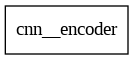

In [ ]:
import tensorflow as tf

# Plot the CNN Encoder model
tf.keras.utils.plot_model(encoder, to_file='encoder_model.png', show_shapes=True)


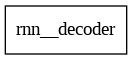

In [ ]:
# Plot the RNN Decoder model

tf.keras.utils.plot_model(decoder, to_file='decoder_model.png', show_shapes=True)


In [ ]:
decoder.summary()

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [36]:
# saving checkpoint

checkpoint_path_ckpt = WORKING_DIR + "/checkpoint_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [37]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

# Training

In [55]:
# Function to save the entire model
def save_model(encoder, decoder):
    tf.saved_model.save(encoder, ckpt_manager.save_checkpoint_path)
    tf.saved_model.save(encoder, ckpt_manager.save_checkpoint_path)


In [38]:
import time

loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        total_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, total_loss


EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()
        

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 2.7276
Epoch 1 Batch 100 Loss 1.6047
Epoch 1 Batch 200 Loss 1.3855
Epoch 1 Batch 300 Loss 1.2827
Epoch 1 Batch 400 Loss 1.2246
Epoch 1 Batch 500 Loss 1.1352
Epoch 1 Loss 1.388142
Time taken for 1 epoch 147.50865387916565 sec

Epoch 2 Batch 0 Loss 1.1255
Epoch 2 Batch 100 Loss 1.0651
Epoch 2 Batch 200 Loss 1.0656
Epoch 2 Batch 300 Loss 0.9842
Epoch 2 Batch 400 Loss 0.9061
Epoch 2 Batch 500 Loss 0.8083
Epoch 2 Loss 1.033535
Time taken for 1 epoch 94.95698618888855 sec

Epoch 3 Batch 0 Loss 1.0416
Epoch 3 Batch 100 Loss 0.9459
Epoch 3 Batch 200 Loss 0.9493
Epoch 3 Batch 300 Loss 0.9144
Epoch 3 Batch 400 Loss 1.0311
Epoch 3 Batch 500 Loss 0.9278
Epoch 3 Loss 0.924135
Time taken for 1 epoch 96.38971734046936 sec

Epoch 4 Batch 0 Loss 0.8278
Epoch 4 Batch 100 Loss 0.8194
Epoch 4 Batch 200 Loss 0.9313
Epoch 4 Batch 300 Loss 0.8915
Epoch 4 Batch 400 Loss 0.8468
Epoch 4 Batch 500 Loss 0.8160
Epoch 4 Loss 0.847039
Time taken for 1 epoch 96.3525562286377 sec

Epoch 5 Batch 0 

In [28]:
start_epoch = 20

In [30]:
import time

loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

        total_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables

        gradients = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, total_loss


EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()
        

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:576: UserWarning: Gradients do not exist for variables ['kernel', 'kernel', 'kernel', 'bias', 'kernel'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 21 Batch 0 Loss 2.6634
Epoch 21 Batch 100 Loss 1.1220
Epoch 21 Batch 200 Loss 1.1230
Epoch 21 Batch 300 Loss 1.1000
Epoch 21 Batch 400 Loss 1.1162
Epoch 21 Batch 500 Loss 0.9987
Epoch 21 Loss 1.121334
Time taken for 1 epoch 134.81014037132263 sec

Epoch 22 Batch 0 Loss 0.8659
Epoch 22 Batch 100 Loss 0.9993
Epoch 22 Batch 200 Loss 0.8248
Epoch 22 Batch 300 Loss 0.8300
Epoch 22 Batch 400 Loss 0.8423
Epoch 22 Batch 500 Loss 0.8150
Epoch 22 Loss 0.900160
Time taken for 1 epoch 92.42923712730408 sec

Epoch 23 Batch 0 Loss 0.8579
Epoch 23 Batch 100 Loss 0.8917
Epoch 23 Batch 200 Loss 0.8934
Epoch 23 Batch 300 Loss 0.8366
Epoch 23 Batch 400 Loss 0.8244
Epoch 23 Batch 500 Loss 0.7251
Epoch 23 Loss 0.802683
Time taken for 1 epoch 91.09856534004211 sec

Epoch 24 Batch 0 Loss 0.7128
Epoch 24 Batch 100 Loss 0.6825
Epoch 24 Batch 200 Loss 0.8110
Epoch 24 Batch 300 Loss 0.7895
Epoch 24 Batch 400 Loss 0.7435
Epoch 24 Batch 500 Loss 0.7006
Epoch 24 Loss 0.735260
Time taken for 1 epoch 91.0997910

In [31]:
ckpt_manager.save()

'/kaggle/working/checkpoint_final/train/ckpt-10'

In [33]:
with open(WORKING_DIR + '/loss_plot.pkl','wb') as f:
    pickle.dump(loss_plot, f)

In [34]:
checkpoint_path_ckpt = WORKING_DIR + "/checkpoint_final/train"

checkpoint_path = checkpoint_path_ckpt
#tf.compat.v2.keras.callbacks.ModelCheckpoint
ckpt = tf.train.Checkpoint(encoder=encoder,
                               decoder=decoder,
                               optimizer = optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    # Restore the latest checkpoint
    ckpt.restore(ckpt_manager.latest_checkpoint)


In [27]:
with open(WORKING_DIR + '/loss_plot.pkl','rb') as r:
    loss_plot = pickle.load(r)

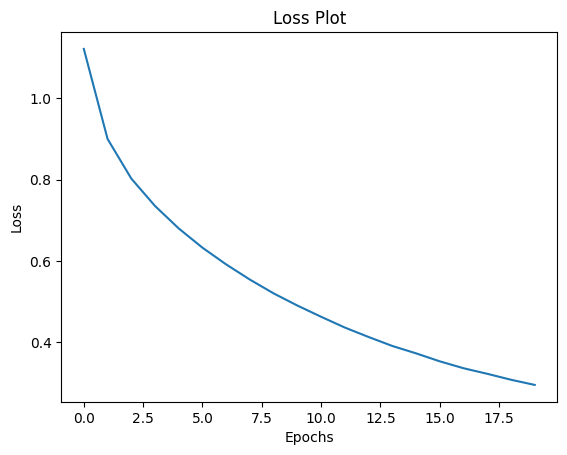

In [28]:
import matplotlib.pyplot as plt

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [29]:
import json
from glob import glob
from PIL import Image

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

#     img_path = tf.constant(BASE_DIR + '/Images/' + image)
#     print(img_path)
#     img = load_image(img_path)[0]

#     temp_input = tf.expand_dims(img, 0)
#     img_tensor_val = image_features_extract_model(temp_input)

    name = image.split('.')[0]

    with open(WORKING_DIR + '/ResNet_Features/' + name + ".pkl","rb") as t:
        img_tensor_val = pickle.load(t)
        
    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<sos>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<eos>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [30]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(os.path.join(BASE_DIR, 'Images',image)))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    #plt.tight_layout()
    plt.show()

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def predict_caption(image):
  real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

  for i in result:
      if i=="<unk>":
          result.remove(i)

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', ' '.join(result))
  plot_attention(image, result, attention_plot)
  # opening the image
  #Image.open(os.path.join(WORKING_DIR, 'Images', image + ".jpg"))
  path = os.path.join(BASE_DIR, 'Images', image)
  img = mpimg.imread(path)
  plt.imshow(img)


tf.Tensor(b'/kaggle/input/Images/177302997_5b2d770a0a.jpg', shape=(), dtype=string)
Real Caption: <sos> a child holding on to the bar while riding a horse on a carousel ride <eos>
Prediction Caption: a child on a fake horse <eos>


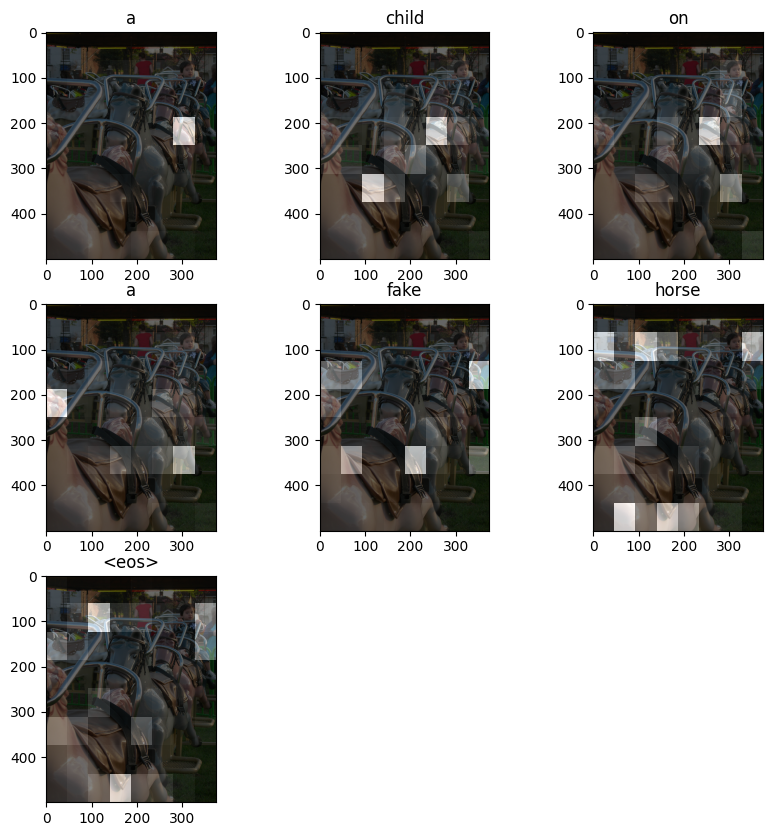

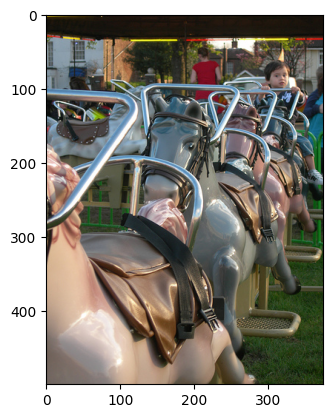

In [50]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

tf.Tensor(b'/kaggle/input/Images/2754898893_95239c1f19.jpg', shape=(), dtype=string)
Real Caption: <sos> a woman standing in front of a beach scene and smiling <eos>
Prediction Caption: a woman in glasses is smiling in front of a city view <eos>


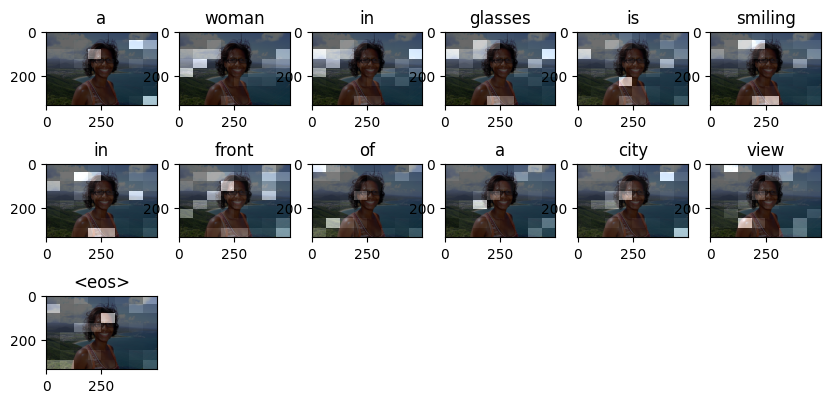

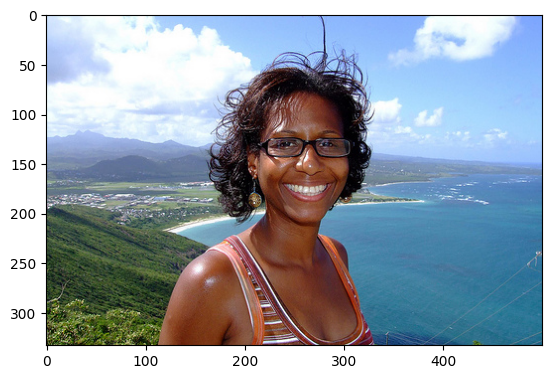

In [51]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

tf.Tensor(b'/kaggle/input/Images/410422753_de506155fa.jpg', shape=(), dtype=string)
Real Caption: <sos> a dog runs through the snow <eos>
Prediction Caption: a dog with his back and brown dog running in the snow <eos>


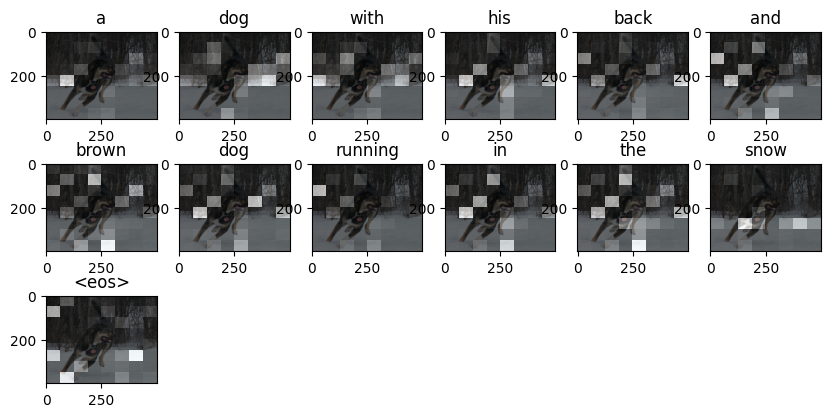

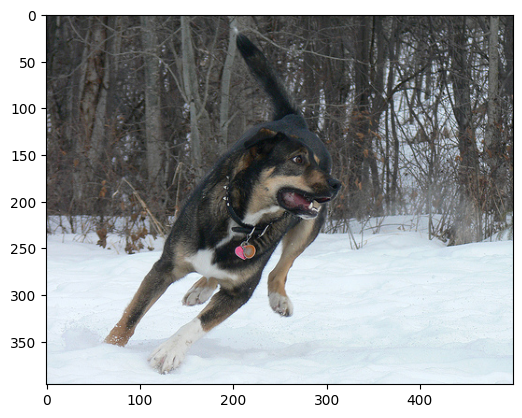

In [53]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

tf.Tensor(b'/kaggle/input/Images/2633201394_ee4a7666ed.jpg', shape=(), dtype=string)
Real Caption: <sos> dog is swimming through water with a piece of wood in its mouth <eos>
Prediction Caption: a brown and tan dog in a body of water <eos>


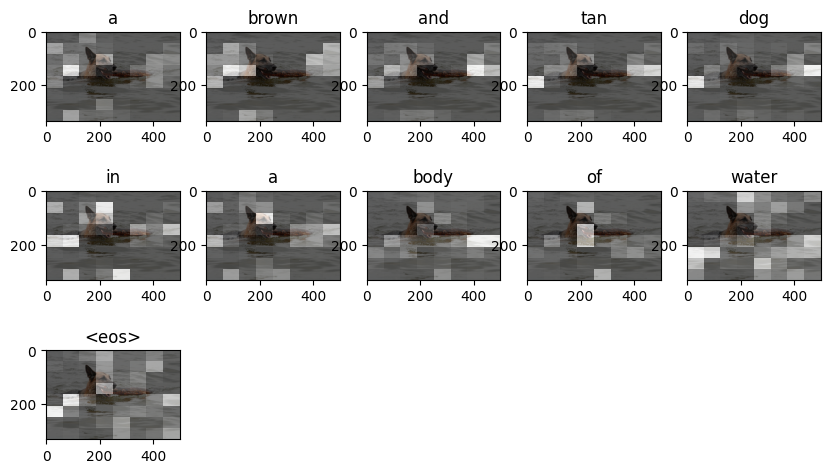

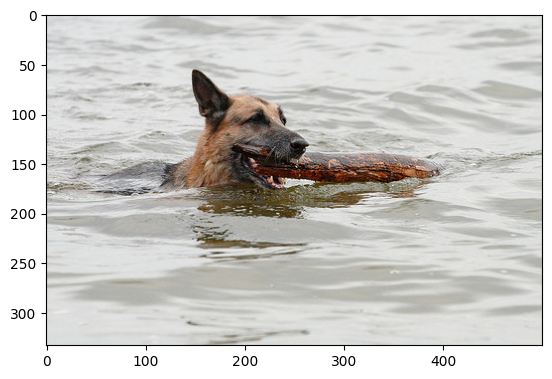

In [55]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
reference = [['this', 'a', 'test','of', 'cricket', 'match']]
candidate = ['this', 'is', 'a', 'test','of', 'cricket', 'match']
print('Individual 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(reference, candidate, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.857143

Individual 2-gram: 0.666667

Individual 3-gram: 0.600000

Individual 4-gram: 0.500000


tf.Tensor(b'/kaggle/input/Images/3578372039_57473f473c.jpg', shape=(), dtype=string)


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


BLEU score: 0.12216944435630524
Real Caption: a person skateboarding down the sidewalk wearing mostly black
Prediction Caption: a man in a large black and brown jacket is driven down the sidewalk


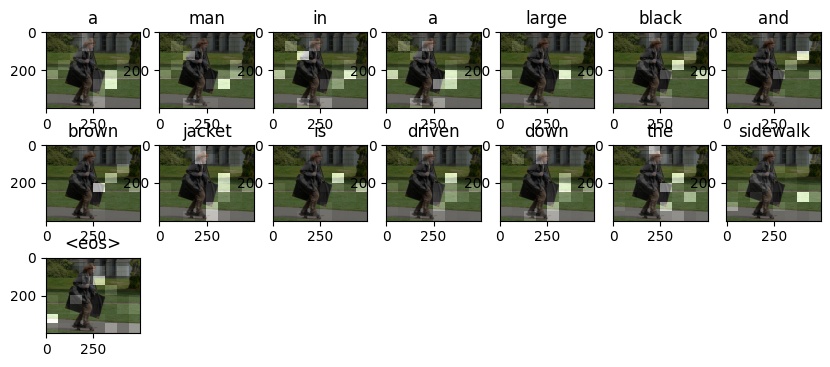

time took to Predict: 3 sec


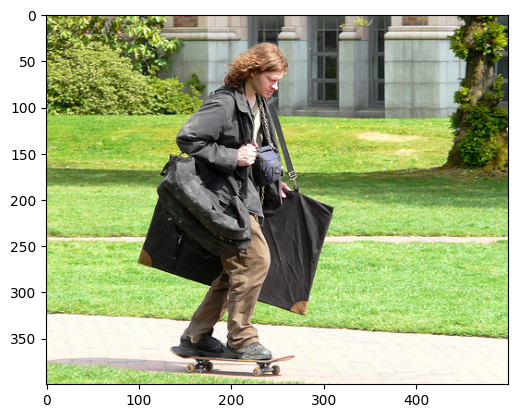

In [56]:
from nltk.translate.bleu_score import sentence_bleu
import time

rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
path = os.path.join(BASE_DIR, 'Images', image)
img = mpimg.imread(path)
plt.imshow(img)

tf.Tensor(b'/kaggle/input/Images/2475300106_b8563111ba.jpg', shape=(), dtype=string)
BLEU score: 22.941573387056174
Real Caption: the yellow dog is running next to a bush on a path in the grass
Prediction Caption: a dog is running through a wooded area


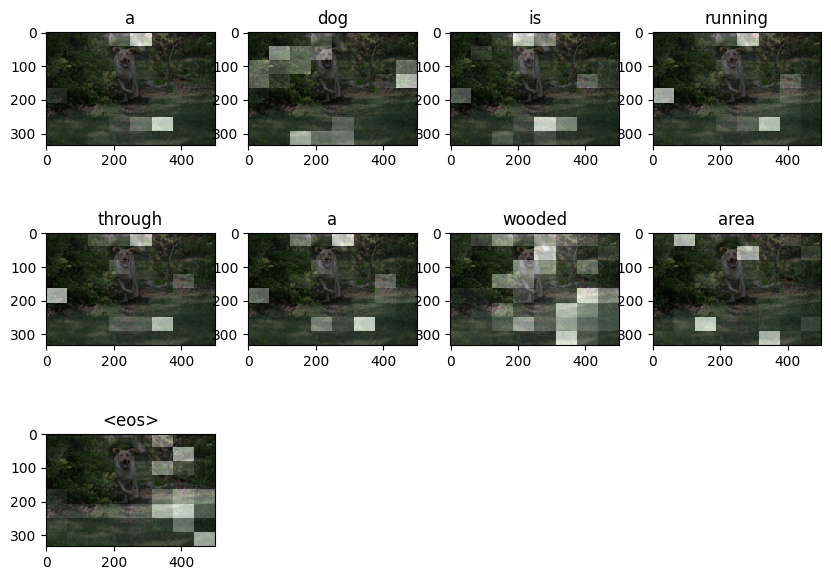

time took to Predict: 2 sec


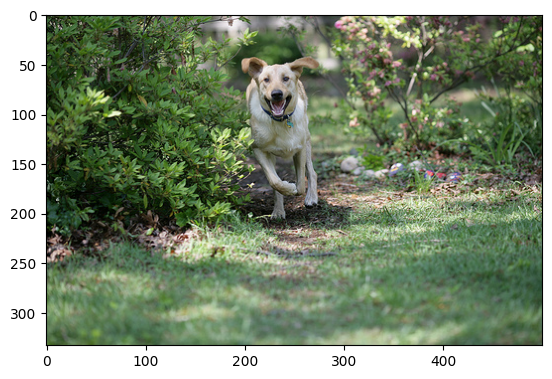

In [59]:
from nltk.translate.bleu_score import sentence_bleu
import time

rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
path = os.path.join(BASE_DIR, 'Images', image)
img = mpimg.imread(path)
plt.imshow(img)

tf.Tensor(b'/kaggle/input/Images/3273625566_2454f1556b.jpg', shape=(), dtype=string)
BLEU score: 0
Real Caption: racing dog with yellow number 8 vest
Prediction Caption: a race dog wearing yellow is running in a race


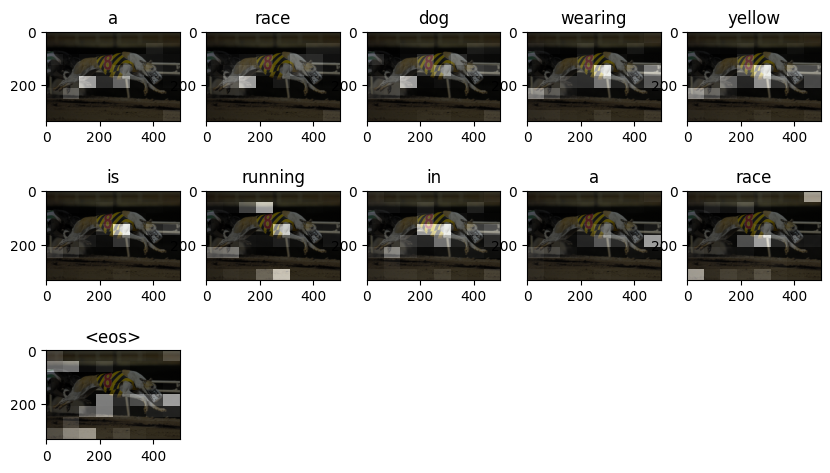

time took to Predict: 2 sec


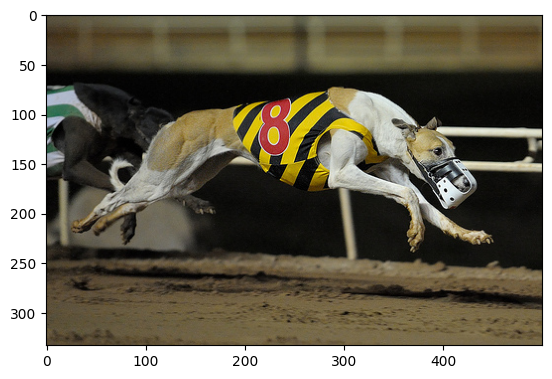

In [67]:
from nltk.translate.bleu_score import sentence_bleu
import time

rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in test_caption[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
path = os.path.join(BASE_DIR, 'Images', image)
img = mpimg.imread(path)
plt.imshow(img)

Real Caption: <sos> the man hold a pole in the air while sitting close to the cliffs edge <eos>
Prediction Caption: a man sits in a chair <eos>


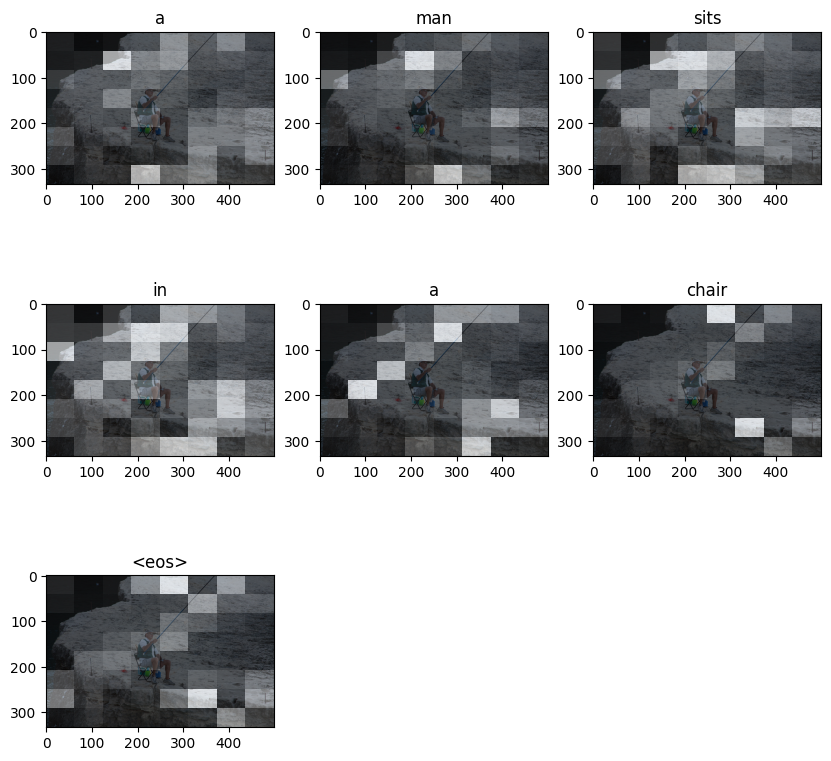

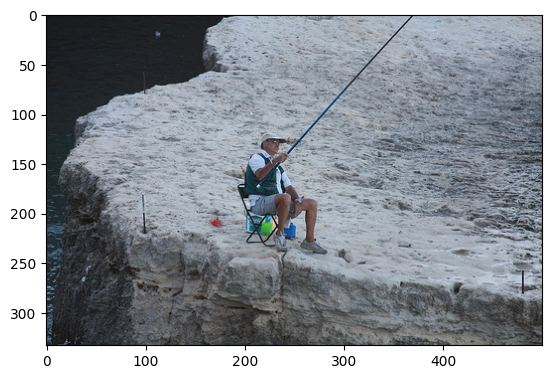

In [37]:
rid = np.random.randint(0, len(test_image))
image = test_image[rid] + '.jpg'

predict_caption(image)

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip

In [ ]:
# import zipfile
# import os
# from IPython.display import FileLink

# def zip_dir(directory = os.path.join(WORKING_DIR), file_name = 'Features.zip'):
#     """
#     zip all the files in a directory

#     Parameters
#     _____
#     directory: str
#         directory needs to be zipped, defualt is current working directory

#     file_name: str
#         the name of the zipped file (including .zip), default is 'directory.zip'

#     Returns
#     _____
#     Creates a hyperlink, which can be used to download the zip file)
#     """
#     os.chdir(directory)
#     zip_ref = zipfile.ZipFile(file_name, mode='w')
#     for folder, _, files in os.walk(directory):
#         for file in files:
#             if file_name in file:
#                 pass
#             else:
#                 zip_ref.write(os.path.join(folder, file))

#     return FileLink(file_name)


In [46]:
#!zip -r file.zip /kaggle/working/Features

In [35]:
# reading captions
import os 

with open(os.path.join(BASE_DIR,"captions.txt"),"r") as c:
  next(c)
  read_captions = c.read() # reading the file 'captions.txt' into read_captions

In [40]:
# creating mapping of image to their captions

from tqdm.notebook import tqdm

def create_mapping(doc):
  mapping = {}

  for line in tqdm(doc.split("\n")):
    if len(line) < 2:
      continue
    words = line.split(",")
    img_name = words[0]
    image_id = img_name.split(".")[0]

    caption = words[1:]
    caption = " ".join(caption)

    if image_id not in mapping:
      mapping[image_id] = []

    mapping[image_id].append(caption)

  return mapping

mapping = create_mapping(read_captions)


  0%|          | 0/40456 [00:00<?, ?it/s]

In [41]:
import pickle

with open(os.path.join(WORKING_DIR,'mapping.pkl'),'wb') as f:
    pickle.dump(mapping, f)

In [43]:
from sklearn.model_selection import train_test_split

image_ids = list(mapping.keys())

train, test = train_test_split(image_ids, test_size = 0.2, random_state = 42)

In [36]:
import pickle

with open(os.path.join(WORKING_DIR,'mapping.pkl'),'rb') as r:
    mapping = pickle.load(r)

In [38]:
def preprocess(mapping):
  for id,captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      
      temp = []
      for word in caption.split():
        if len(word) > 1:
          temp.append(word)
      caption = "<SOS> " + ' '.join(temp) + " <EOS>"
      captions[i] = caption

preprocess(mapping)


In [39]:
mapping['3329793486_afc16663cc']

['<SOS> man on snowboard is grinding ramp <EOS>',
 '<SOS> skier on snowy ski jump <EOS>',
 '<SOS> snowboarder is riding down ramp amidst snow <EOS>',
 '<SOS> snowboarder prepares to go over ramp <EOS>',
 '<SOS> Snowboarding practice on snowy hillside <EOS>']

In [44]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction


actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    #print(captions)
    
    key = key + ".jpg"
    result, _ = evaluate(key)
    
    for i in result:
      if i=="<unk>":
          result.remove(i)
    
    actual_captions = []
    
        
    for caption in captions:
        cap = list()
        words = caption.split()
        
        for word in words:
            if word in ['<SOS>','<EOS>']:
                continue
            cap.append(word)
        actual_captions.append(cap)
    
    actual.append(actual_captions)
    predicted.append(result)
    
#     print(actual)
#     print(predicted)
   

print("Bleu Score for Image Captioning(Inceptionv3)")

smoothing_function = SmoothingFunction()

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function = smoothing_function.method1))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function = smoothing_function.method1))
    
    

  0%|          | 0/1619 [00:00<?, ?it/s]

Bleu Score for Image Captioning(Inceptionv3)
BLEU-1: 0.465876
BLEU-2: 0.373315


In [45]:
with open(WORKING_DIR + '/actual.pkl','wb') as a:
    pickle.dump(actual, a)
    
with open(WORKING_DIR + '/predicted.pkl','wb') as p:
    pickle.dump(predicted, p)

In [51]:
print("Bleu Score for Image Captioning(ResNet50)")

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smoothing_function.method1))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0),smoothing_function=smoothing_function.method1))

Bleu Score for Image Captioning(ResNet50)
BLEU-1: 0.467461
BLEU-2: 0.364065
